## Assessing impact of various DL tricks (eg Regularisation, Augmentation) on finetuned iNaturalist model performance

Augmentation in Pytorch: https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde

L1/L2 Regularisation: https://python-code.dev/articles/242716633

First download V4 dataset:

In [2]:
# check metadata csv file (dataset-v4.csv) is in google drive

# mount google drive
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

# peek contents of dataset-v4.csv
!head /content/drive/MyDrive/team_challenge/dataset-v4.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
,annotation_id,annotator,choice,created_at,id,image,lead_time,updated_at,labels,subset
0,4024,10,Clover,2024-07-16T12:15:40.960299Z,87231,OV3XXX_1_582_970.jpg,5.152,2024-07-16T12:15:40.960318Z,['Clover'],Train
1,19621,1,"{""choices"":[""Grass"",""Dung""]}",2024-07-26T17:43:59.440503Z,52689,Cow Dung_Livia_378_582_194.jpg,1.443,2024-07-26T17:43:59.440522Z,"['Grass', 'Dung']",Train
2,16876,3,"{""choices"":[""Clover"",""Grass""]}",2024-07-23T10:57:48.626335Z,50010,Clover_Stev_348_1552_776.jpg,1.23,2024-07-23T10:57:48.626352Z,"['Clover', 'Grass']",Train
3,14621,5,"{""choices"":[""Grass"",""Soil""]}",2024-07-18T16:26:16.223214Z,19317,Bare Soil_Maxwell_16_388_582.jpg,1.345,2024-07-18T16:26:16.223233Z,"['Grass', 'Soil']",Train
4,12780,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T16:51:30.637064Z,113179,More Clover_13_1312_1164.jpg,1.319,2024-07-17T16:51:30.637

In [3]:
# Generate df and perform processing

import pandas as pd

csv_path = "/content/drive/MyDrive/team_challenge/dataset-v4.csv"
main_df = pd.read_csv(csv_path)
main_df['image_name'] = main_df['image']
# main_df['image_name'] = main_df['image'].apply(lambda x: x.split('/')[-1].replace('%20', ' ')) # Ensure URL encoded spaces are replaced
main_df_noNaN = main_df.dropna(subset=['labels'])

print(f"{len(main_df) - len(main_df_noNaN)} images with no labels removed")

main_df

0 images with no labels removed


,Unnamed: 0,annotation_id,annotator,choice,created_at,id,image,lead_time,updated_at,labels,subset,image_name
0,0,4024,10,Clover,2024-07-16T12:15:40.960299Z,87231,OV3XXX_1_582_970.jpg,5.152,2024-07-16T12:15:40.960318Z,['Clover'],Train,OV3XXX_1_582_970.jpg
1,1,19621,1,"{""choices"":[""Grass"",""Dung""]}",2024-07-26T17:43:59.440503Z,52689,Cow Dung_Livia_378_582_194.jpg,1.443,2024-07-26T17:43:59.440522Z,"['Grass', 'Dung']",Train,Cow Dung_Livia_378_582_194.jpg
2,2,16876,3,"{""choices"":[""Clover"",""Grass""]}",2024-07-23T10:57:48.626335Z,50010,Clover_Stev_348_1552_776.jpg,1.230,2024-07-23T10:57:48.626352Z,"['Clover', 'Grass']",Train,Clover_Stev_348_1552_776.jpg
3,3,14621,5,"{""choices"":[""Grass"",""Soil""]}",2024-07-18T16:26:16.223214Z,19317,Bare Soil_Maxwell_16_388_582.jpg,1.345,2024-07-18T16:26:16.223233Z,"['Grass', 'Soil']",Train,Bare Soil_Maxwell_16_388_582.jpg
4,4,12780,5,"{""choices"":[""Clover"",""Grass""]}",2024-07-17T16:51:30.637064Z,113179,More Clover_13_1312_1164.jpg,1.319,2024-07-17T16:51:30.637082Z,"['Clover', 'Grass']",Train,More Clover_13_1312_1164.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
2886,2886,189,3,"{""choices"":[""Grass"",""Dung""]}",2024-07-11T10:03:33.844396Z,93550,Sheep Dung_Livia_837_582_388.jpg,4.678,2024-07-11T10:03:33.844426Z,"['Grass', 'Dung']",Train,Sheep Dung_Livia_837_582_388.jpg
2887,2887,13617,12,"{""choices"":[""Grass"",""Dung""]}",2024-07-18T09:19:45.344062Z,57523,Cow Dung_Stev_432_1312_1164.jpg,852.126,2024-07-18T09:19:45.344080Z,"['Grass', 'Dung']",Train,Cow Dung_Stev_432_1312_1164.jpg
2888,2888,11880,12,"{""choices"":[""Grass"",""Dung""]}",2024-07-17T15:19:44.796236Z,55015,Cow Dung_Livia_405_1164_0.jpg,1.928,2024-07-17T15:19:44.796254Z,"['Grass', 'Dung']",Train,Cow Dung_Livia_405_1164_0.jpg
2889,2889,2284,2,"{""choices"":[""Grass"",""Dung""]}",2024-07-14T13:03:38.691054Z,51060,Cow Dung_Fran_359_970_388.jpg,1.478,2024-07-14T13:03:38.691072Z,"['Grass', 'Dung']",Val,Cow Dung_Fran_359_970_388.jpg


In [11]:
# Download images zips
!wget https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/data.zip

--2024-08-13 14:08:03--  https://sensor-cdt-group-project.s3.eu-north-1.amazonaws.com/data.zip
Resolving sensor-cdt-group-project.s3.eu-north-1.amazonaws.com (sensor-cdt-group-project.s3.eu-north-1.amazonaws.com)... 16.12.9.14, 16.12.11.10
Connecting to sensor-cdt-group-project.s3.eu-north-1.amazonaws.com (sensor-cdt-group-project.s3.eu-north-1.amazonaws.com)|16.12.9.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1779842156 (1.7G) [binary/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.66G  19.6MB/s    in 88s     

2024-08-13 14:09:31 (19.3 MB/s) - ‘data.zip’ saved [1779842156/1779842156]



In [12]:
# Make dir to store images & unzip
!mkdir -p finetune_data
!unzip -q data.zip -d finetune_data

Prepare pretrained iNaturalist

In [13]:
# Download pretrained iNaturalist model

# First go to this dropbox (https://cornell.app.box.com/s/bnyhq5lwobu6fgjrub44zle0pyjijbmw) and generate download popup to get link to wget weights
!wget "https://public.boxcloud.com/d/1/b1!alT3l9fCkw4c1ur1SDHIJybqrYHldS5S4JeJx9TNl8mNfi5suQpUq4pzrxplOikAan6OzIcxlIGnCxU-YPIT7DTgiM4AWIq2YrGXjlO8m6a06bVBA6DpcvxbUDppkcrEFaqWU-b8uDi38KAGPw7LLQwlMM-l7Zgp1lB9b04Nus-LOymTP7FBERMuvkcUjqJFzP_mKYRRty13e_O4nOZcXJMvcdg5b2w-aw5HCAUC_0Z4phkcnmmDDTJjlyeH6voxi5X5E1Ebn7VvKtkI1VvOhnrK96rHQBKC0D_MO6CvDi37WOfXLpC21GutgnDH0hqPm2XfFRYczKmENxzCItd5wn4uEElHAqxpvL3zaeNYDk5qCfU2hWOtxxt_speuwa-BTwBB48mByppbwomrJtrQq0IYZMsgrWUuOSfKGBPrSxwXXvM_0QyZ_z-xcLD2dyrH3Uny-XgT6mQw3P_GGgTFcO6_Zoo5l7UOdLdoiwe4iK3SieySi4J98C1mW6yW6s4f9hQQ1QUSXlasIzL-DR75BKQWfLiEErbJlxp7V8peCZBESitOn2HTLUa4xLdIpSv1OGBkhXnjP-N9rgxpYU9kN2I-_RxuwErWaU6pCKeFOspnacfFCWrMRapCYZ-W5tnt7CkrhMCMH1u7dshugJ7qbk0wLnu58JESqEB6rJNuhcX86VkoX4ibVAj_uwaZzppHCzwrFZy09si0ghaq6vMPSIUTDFkD6BsevFd7IAAu2wuqameDz5DreNLjJf_DYXsE73oFXQZitIOLu6iT21dVxzA_Wv3n-NSzOiXHqJqxRQE9tTh67L5rqdJxyrE2tmxCYkDp-GQgnChEluRQ_6SALmE1jRqzf4siziOc8QXPO8yNULD9BLC4Vbqu176dtRCdKNwXJyrtWb6UhfHMfkUW6zovqywf39CDbI55-5ADUsjUf2rh3obTxJjpJRzlgJZcvfhQLJ4BQyDAwWgvWyojnpQ1IhB_FwrEUkhbbrlhDAnPLv_XTO6wghSb1Cw6Q6KnHEo-A8d0EVcUivqjY-rSMvChRe75QYZScHPGFTo0ui-hPljf2wrJh1Rumnv_xfCOQsI2c4SpZuwHzrU2TSiR0Wg1UTLvgIKicHBolmlQIU5t_QCPZQegetm1m9iMoGC3FA_A_J9oSRkLIxuw77qlHTuNUZ2EQrGVhYHUEFw2YpCshFeGaYopHuyfO8-BI_-l_ToDPAYyAhfzgEnFFEee6cQUkzk36yomT3OF7oAEsoVBO8EhKN4gjmnvC8-VTxcXKuc_rmjnAREDauPjDEbm60JEJrQbUiJncKLW6wA./download" -O cvpr21_newt_pretrained_models.tar.gz

# Unzip models
!tar -xzf cvpr21_newt_pretrained_models.tar.gz

--2024-08-13 14:10:05--  https://public.boxcloud.com/d/1/b1!alT3l9fCkw4c1ur1SDHIJybqrYHldS5S4JeJx9TNl8mNfi5suQpUq4pzrxplOikAan6OzIcxlIGnCxU-YPIT7DTgiM4AWIq2YrGXjlO8m6a06bVBA6DpcvxbUDppkcrEFaqWU-b8uDi38KAGPw7LLQwlMM-l7Zgp1lB9b04Nus-LOymTP7FBERMuvkcUjqJFzP_mKYRRty13e_O4nOZcXJMvcdg5b2w-aw5HCAUC_0Z4phkcnmmDDTJjlyeH6voxi5X5E1Ebn7VvKtkI1VvOhnrK96rHQBKC0D_MO6CvDi37WOfXLpC21GutgnDH0hqPm2XfFRYczKmENxzCItd5wn4uEElHAqxpvL3zaeNYDk5qCfU2hWOtxxt_speuwa-BTwBB48mByppbwomrJtrQq0IYZMsgrWUuOSfKGBPrSxwXXvM_0QyZ_z-xcLD2dyrH3Uny-XgT6mQw3P_GGgTFcO6_Zoo5l7UOdLdoiwe4iK3SieySi4J98C1mW6yW6s4f9hQQ1QUSXlasIzL-DR75BKQWfLiEErbJlxp7V8peCZBESitOn2HTLUa4xLdIpSv1OGBkhXnjP-N9rgxpYU9kN2I-_RxuwErWaU6pCKeFOspnacfFCWrMRapCYZ-W5tnt7CkrhMCMH1u7dshugJ7qbk0wLnu58JESqEB6rJNuhcX86VkoX4ibVAj_uwaZzppHCzwrFZy09si0ghaq6vMPSIUTDFkD6BsevFd7IAAu2wuqameDz5DreNLjJf_DYXsE73oFXQZitIOLu6iT21dVxzA_Wv3n-NSzOiXHqJqxRQE9tTh67L5rqdJxyrE2tmxCYkDp-GQgnChEluRQ_6SALmE1jRqzf4siziOc8QXPO8yNULD9BLC4Vbqu176dtRCdKNwXJyrtWb6UhfHMfkUW6zovqywf39CDbI55-5ADUsjU

In [14]:
# Functions for preparing a multilabel iNaturalist model

import torch
from torchvision.models import resnet50

def load_iNaturalist_model():

  model = resnet50()
  num_iNaturalist_classes = 10000 # 10,000 classes including all species
  model.fc = torch.nn.Linear(in_features=2048, out_features=num_iNaturalist_classes)

  weights_file_path = "cvpr21_newt_pretrained_models/pt/inat2021_supervised_large.pth.tar"
  checkpoint = torch.load(weights_file_path, map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['state_dict'])

  return model

# Define a new class to wrap the model with a sigmoid activation
class MultiLabelResNet(torch.nn.Module):
    def __init__(self, original_model, num_classes):
        super(MultiLabelResNet, self).__init__()
        self.resnet = original_model
        self.resnet.fc = torch.nn.Linear(in_features=2048, out_features=num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        x = self.sigmoid(x)
        return x

In [15]:
# Create model for finetuning on non-augmented data

new_num_classes = 4 # {Grass, Clover, Soil, Dung}

iNaturalist_model = load_iNaturalist_model()
iNaturalist_model = MultiLabelResNet(iNaturalist_model, new_num_classes)

Finetuning on non-augmented data

In [16]:
# Prepare dataset class and transform

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import v2 # NB using v2 this time
import os
import ast
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
        def __init__(self, dataframe, img_dir, transform=None):
            self.dataframe = dataframe
            self.img_dir = img_dir
            self.transform = transform
            self.label_map = {'Grass': 0, 'Clover': 1, 'Soil': 2, 'Dung': 3} # NB 4 classes
            self.num_classes = len(self.label_map)
            self.class_names = list(self.label_map.keys())
            self.image_paths = [os.path.join(self.img_dir, img_name) for img_name in self.dataframe.iloc[:, 6]]

        def __len__(self):
            return len(self.dataframe)

        def __getitem__(self, idx):
            img_name = self.image_paths[idx]
            image = Image.open(img_name).convert("RGB")

            # Extract and process the label string
            label_str = self.dataframe.iloc[idx, 9]
            label_list = ast.literal_eval(label_str)  # Safely evaluate the string to a list
            label_indices = [self.label_map[label] for label in label_list]  # Map to indices
            label_tensor = torch.tensor(label_indices, dtype=torch.long)

            label_onehot = nn.functional.one_hot(label_tensor, num_classes=self.num_classes)
            label_onehot = label_onehot.max(dim=0)[0].float()

            if self.transform:
                image = self.transform(image)

            return image, label_onehot

        def get_image_path(self, idx):
            return self.image_paths[idx]

        def get_labels(self, idx):
            return self.dataframe.iloc[idx, 9]

std_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [17]:
# Prepare dataloaders

img_dir = 'finetune_data/'

train_df = main_df[main_df['subset'] == 'Train']
val_df = main_df[main_df['subset'] == 'Val']

train_dataset = CustomDataset(dataframe=train_df, img_dir=img_dir, transform=std_transform)
val_dataset = CustomDataset(dataframe=val_df, img_dir=img_dir, transform=std_transform)

label_map = train_dataset.label_map

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Train set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')

Train set size: 2290
Validation set size: 601


In [18]:
!pip -q install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 20.0 MB/s eta 0:00:00


In [19]:
import torch
import keras
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm
from torchmetrics.classification import MultilabelF1Score

def fine_tune_model(model, device, train_loader, val_loader, optimiser, loss_function, num_epochs=20, patience=5):

    ''' Inspired by https://keras.io/guides/writing_a_custom_training_loop_in_torch/ '''

    start = time.time()

    # Use keras function for computing accuracy
    # NB labels are one-hot encoded
    # NBB BinaryAccuracy rather than Categorical (less harsh)
    train_acc_metric = keras.metrics.BinaryAccuracy()
    val_acc_metric = keras.metrics.BinaryAccuracy()

    # Move F1 metrics to the correct device
    train_f1_metric = MultilabelF1Score(num_labels=new_num_classes).to(device)
    val_f1_metric = MultilabelF1Score(num_labels=new_num_classes).to(device)

    # lists to store loss/accuracy tuples of each epoch
    epoch_train_stats = []
    epoch_val_stats = []

    best_val_f1 = 0.0
    epochs_no_improve = 0
    best_model_weights = None

    # Initial evaluation before fine-tuning
    def evaluate_model(model, data_loader, loss_function, acc_metric, f1_metric):
        model.eval()
        running_loss = 0.0
        num_batches = 0
        with torch.no_grad():
            for inputs, targets in tqdm(data_loader, leave=False):
                inputs = inputs.to(device)
                targets = targets.to(device)

                logits = model(inputs)
                loss = loss_function(logits, targets)

                acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())
                f1_metric.update(logits, targets)

                running_loss += loss.item()
                num_batches += 1

        epoch_loss = running_loss / num_batches
        epoch_acc = acc_metric.result().numpy()  # Convert to numpy
        epoch_f1 = f1_metric.compute().item()  # Convert to scalar
        f1_metric.reset()
        acc_metric.reset_state()

        return epoch_loss, epoch_acc, epoch_f1

    # Evaluate model on training and validation datasets before training
    initial_train_loss, initial_train_acc, initial_train_f1 = evaluate_model(model, train_loader, loss_function, train_acc_metric, train_f1_metric)
    epoch_train_stats.append((initial_train_loss, initial_train_acc, initial_train_f1))

    initial_val_loss, initial_val_acc, initial_val_f1 = evaluate_model(model, val_loader, loss_function, val_acc_metric, val_f1_metric)
    epoch_val_stats.append((initial_val_loss, initial_val_acc, initial_val_f1))

    print(f'Initial Train loss: {initial_train_loss:.2f}, Train accuracy: {initial_train_acc:.2f}, Train f1: {initial_train_f1:.2f} '
          f'Val loss: {initial_val_loss:.2f}, Val accuracy: {initial_val_acc:.2f}, Val f1: {initial_val_f1:.2f}')

    for epoch in range(num_epochs):

        print(f"epoch {epoch+1}/{num_epochs}")

        # Set model to training mode
        model.train()

        running_loss = 0.0
        num_batches = 0

        for inputs, targets in tqdm(train_loader, leave=False):

            inputs = inputs.to(device)  # Assuming 'device' is properly set
            targets = targets.to(device)

            optimiser.zero_grad()

            # Forward pass
            logits = model(inputs)
            loss = loss_function(logits, targets)

            # Backward pass
            loss.backward()

            # Optimiser variable updates
            optimiser.step()

            # Update training metric
            train_acc_metric.update_state(targets.cpu().detach().numpy(), logits.cpu().detach().numpy())
            train_f1_metric.update(logits, targets)

            # Increment loss & batch count
            running_loss += loss.item()
            num_batches += 1

        # Get train loss & accuracy for the epoch
        train_epoch_loss = running_loss / num_batches
        train_epoch_acc = train_acc_metric.result().numpy()  # Convert to numpy
        train_epoch_f1 = train_f1_metric.compute().item()  # Convert to scalar
        epoch_train_stats.append((train_epoch_loss,train_epoch_acc, train_epoch_f1))

        # Run a validation loop at the end of each epoch
        model.eval()
        val_running_loss = 0.0
        val_num_batches = 0

        with torch.no_grad():
            for x_batch_val, y_batch_val in tqdm(val_loader, leave=False):
                x_batch_val = x_batch_val.to(device)
                y_batch_val = y_batch_val.to(device)

                # Forward pass
                val_logits = model(x_batch_val)
                val_loss = loss_function(val_logits, y_batch_val)

                # Update validation metrics
                val_acc_metric.update_state(y_batch_val.cpu().detach().numpy(), val_logits.cpu().detach().numpy())
                val_f1_metric.update(val_logits, y_batch_val)

                # Increment validation loss & batch count
                val_running_loss += val_loss.item()
                val_num_batches += 1

        # Get val loss & accuracy for the epoch
        val_epoch_loss = val_running_loss / val_num_batches
        val_epoch_acc = val_acc_metric.result().numpy()  # Convert to numpy
        val_epoch_f1 = val_f1_metric.compute().item()  # Convert to scalar

        epoch_val_stats.append((val_epoch_loss, val_epoch_acc, val_epoch_f1))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()
        train_f1_metric.reset()
        val_f1_metric.reset()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train loss: {train_epoch_loss:.2f}, Train accuracy: {train_epoch_acc:.2f}, Train f1: {train_epoch_f1:.2f}, Val loss: {val_epoch_loss:.2f}, Val accuracy: {val_epoch_acc:.2f}, Val f1: {val_epoch_f1:.2f}')

        # Check for early stopping based on validation accuracy
        if val_epoch_f1 > best_val_f1:
            best_val_f1 = val_epoch_f1
            epochs_no_improve = 0
            best_model_weights = model.state_dict().copy()
            print(f"Best model saved with f1: {best_val_f1:.2f}")
        else:
            epochs_no_improve += 1
            print(f"Validation f1 not improved {epochs_no_improve} times.")

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

    # Load the best model weights after training
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print("Loaded the best model weights.")

    elapsed_time = time.time() - start
    print('Fine-tuning complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

    return model, epoch_train_stats, epoch_val_stats


In [20]:
# Finetune model

# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define loss function and optimiser
loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
iNaturalist_optimiser = optim.Adam(iNaturalist_model.parameters(), lr=0.0001)  # Adjust learning rate as needed

iNaturalist_model.to(device) # Detect if GPU is available

# Fine-tune the model
iNaturalist_model, iNaturalist_train_stats, iNtauralist_val_stats = fine_tune_model(model         = iNaturalist_model,
                                                                                    device        = device,
                                                                                    train_loader  = train_loader,
                                                                                    val_loader    = val_loader,
                                                                                    optimiser     = iNaturalist_optimiser,
                                                                                    loss_function = loss_function,
                                                                                    num_epochs    = 10)

Initial Train loss: 0.67, Train accuracy: 0.55, Train f1: 0.59 Val loss: 0.67, Val accuracy: 0.53, Val f1: 0.57
epoch 1/10


Epoch [1/10], Train loss: 0.23, Train accuracy: 0.91, Train f1: 0.89, Val loss: 0.18, Val accuracy: 0.94, Val f1: 0.93
Best model saved with f1: 0.93
epoch 2/10


Epoch [2/10], Train loss: 0.11, Train accuracy: 0.96, Train f1: 0.96, Val loss: 0.15, Val accuracy: 0.94, Val f1: 0.93
Best model saved with f1: 0.93
epoch 3/10


Epoch [3/10], Train loss: 0.06, Train accuracy: 0.98, Train f1: 0.98, Val loss: 0.17, Val accuracy: 0.94, Val f1: 0.93
Validation f1 not improved 1 times.
epoch 4/10


Epoch [4/10], Train loss: 0.04, Train accuracy: 0.99, Train f1: 0.99, Val loss: 0.17, Val accuracy: 0.95, Val f1: 0.94
Best model saved with f1: 0.94
epoch 5/10


Epoch [5/10], Train loss: 0.02, Train accuracy: 1.00, Train f1: 1.00, Val loss: 0.17, Val accuracy: 0.94, Val f1: 0.94
Best model saved with f1: 0.94
epoch 6/10


Epoch [6/10], Train loss: 0.01, Train accuracy: 1.00, Train f1: 1.00, Val loss: 0.19, Val accuracy: 0.95, Val f1: 0.94
Best model saved with f1: 0.94
epoch 7/10


Epoch [7/10], Train loss: 0.01, Train accuracy: 1.00, Train f1: 1.00, Val loss: 0.17, Val accuracy: 0.95, Val f1: 0.94
Best model saved with f1: 0.94
epoch 8/10


Epoch [8/10], Train loss: 0.01, Train accuracy: 1.00, Train f1: 1.00, Val loss: 0.25, Val accuracy: 0.94, Val f1: 0.94
Validation f1 not improved 1 times.
epoch 9/10


Epoch [9/10], Train loss: 0.01, Train accuracy: 1.00, Train f1: 1.00, Val loss: 0.25, Val accuracy: 0.94, Val f1: 0.94
Validation f1 not improved 2 times.
epoch 10/10


Epoch [10/10], Train loss: 0.02, Train accuracy: 1.00, Train f1: 0.99, Val loss: 0.24, Val accuracy: 0.94, Val f1: 0.93
Validation f1 not improved 3 times.
Loaded the best model weights.
Fine-tuning complete in 5m 57s


In [21]:
# Save the model
torch.save(iNaturalist_model.state_dict(), '/content/drive/MyDrive/team_challenge/240808_multiclass_iNaturalist.pth')

In [22]:
# function for plotting training history

import matplotlib.pyplot as plt

def plot_training_history(train_stats, val_stats, title):

  epochs = range(1, len(train_stats) + 1)
  train_losses = [entry[0] for entry in train_stats]
  train_accuracies = [entry[1] for entry in train_stats]
  val_losses = [entry[0] for entry in val_stats]
  val_accuracies = [entry[1] for entry in val_stats]

  fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

  fig.suptitle(title)

  train_colour = 'tab:blue'
  val_colour = 'tab:red'
  # Plotting loss
  ax1.plot(epochs, train_losses, label='Train Loss', color=train_colour)
  ax1.plot(epochs, val_losses, label='Val Loss', color=val_colour)
  ax1.set_ylabel('Loss')
  ax1.legend()

  # Plot accuracy
  ax2.plot(epochs, train_accuracies, label='Train Accuracy', color=train_colour)
  ax2.plot(epochs, val_accuracies, label='Val Accuracy', color=val_colour)
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()

  plt.tight_layout()
  return plt.show()

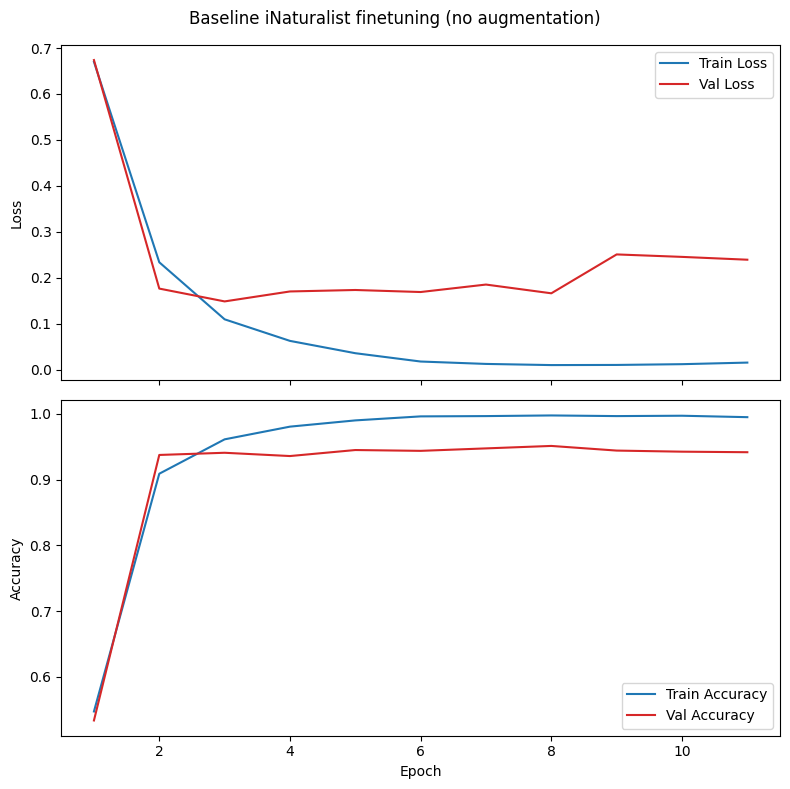

In [23]:
plot_training_history(iNaturalist_train_stats, iNtauralist_val_stats, "Baseline iNaturalist finetuning (no augmentation)")

Now train model on augmented training data

In [24]:
# Define gaussian blur augmentation function

blur_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1.0)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
# Prepare augmented (using gaussian blurring) training data

aug_train_dataset = CustomDataset(dataframe=train_df, img_dir=img_dir, transform=blur_transform)
aug_train_loader = DataLoader(aug_train_dataset, batch_size=32, shuffle=True)

In [26]:
# Create model for finetuning on augmented data

aug_iNaturalist_model = load_iNaturalist_model()
aug_iNaturalist_model = MultiLabelResNet(aug_iNaturalist_model, new_num_classes) # same num classes as before

In [27]:
# Finetune model on augmented data

# Define loss function and optimiser
loss_function = nn.BCELoss()  # Binary cross-entropy loss for one-hot labels
aug_iNaturalist_optimiser = optim.Adam(aug_iNaturalist_model.parameters(), lr=0.0001)  # Adjust learning rate as needed

aug_iNaturalist_model.to(device) # Detect if GPU is available

# Fine-tune the model
aug_iNaturalist_model, aug_iNaturalist_train_stats, aug_iNtauralist_val_stats = fine_tune_model(model         = aug_iNaturalist_model,
                                                                                                device        = device,
                                                                                                train_loader  = aug_train_loader,
                                                                                                val_loader    = val_loader,
                                                                                                optimiser     = aug_iNaturalist_optimiser,
                                                                                                loss_function = loss_function,
                                                                                                num_epochs    = 10)

Initial Train loss: 0.70, Train accuracy: 0.53, Train f1: 0.48 Val loss: 0.70, Val accuracy: 0.53, Val f1: 0.47
epoch 1/10


Epoch [1/10], Train loss: 0.24, Train accuracy: 0.90, Train f1: 0.88, Val loss: 0.16, Val accuracy: 0.94, Val f1: 0.94
Best model saved with f1: 0.94
epoch 2/10


Epoch [2/10], Train loss: 0.12, Train accuracy: 0.96, Train f1: 0.95, Val loss: 0.17, Val accuracy: 0.93, Val f1: 0.92
Validation f1 not improved 1 times.
epoch 3/10


Epoch [3/10], Train loss: 0.06, Train accuracy: 0.98, Train f1: 0.98, Val loss: 0.16, Val accuracy: 0.94, Val f1: 0.94
Best model saved with f1: 0.94
epoch 4/10


Epoch [4/10], Train loss: 0.04, Train accuracy: 0.99, Train f1: 0.99, Val loss: 0.16, Val accuracy: 0.94, Val f1: 0.94
Validation f1 not improved 1 times.
epoch 5/10


Epoch [5/10], Train loss: 0.03, Train accuracy: 0.99, Train f1: 0.99, Val loss: 0.18, Val accuracy: 0.95, Val f1: 0.94
Best model saved with f1: 0.94
epoch 6/10


Epoch [6/10], Train loss: 0.03, Train accuracy: 0.99, Train f1: 0.99, Val loss: 0.17, Val accuracy: 0.94, Val f1: 0.93
Validation f1 not improved 1 times.
epoch 7/10


Epoch [7/10], Train loss: 0.02, Train accuracy: 0.99, Train f1: 0.99, Val loss: 0.20, Val accuracy: 0.95, Val f1: 0.94
Best model saved with f1: 0.94
epoch 8/10


Epoch [8/10], Train loss: 0.01, Train accuracy: 1.00, Train f1: 0.99, Val loss: 0.17, Val accuracy: 0.95, Val f1: 0.95
Best model saved with f1: 0.95
epoch 9/10


Epoch [9/10], Train loss: 0.01, Train accuracy: 1.00, Train f1: 1.00, Val loss: 0.16, Val accuracy: 0.95, Val f1: 0.95
Validation f1 not improved 1 times.
epoch 10/10


Epoch [10/10], Train loss: 0.01, Train accuracy: 1.00, Train f1: 1.00, Val loss: 0.19, Val accuracy: 0.95, Val f1: 0.95
Validation f1 not improved 2 times.
Loaded the best model weights.
Fine-tuning complete in 7m 35s


In [28]:
# Save the model
torch.save(aug_iNaturalist_model.state_dict(), '/content/drive/MyDrive/team_challenge/240808_augmented_multiclass_iNaturalist.pth')

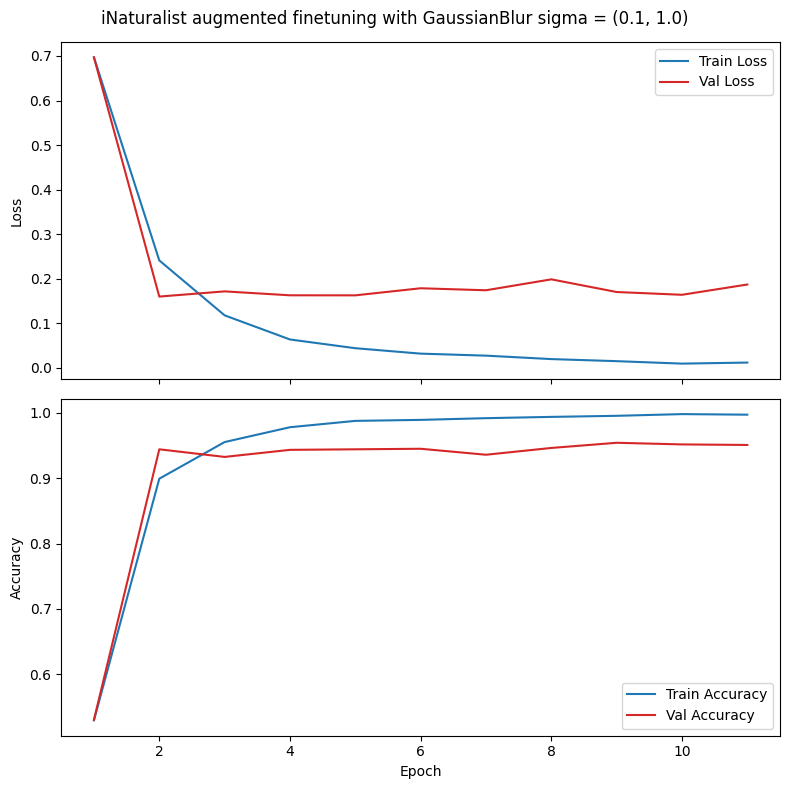

In [29]:
plot_training_history(aug_iNaturalist_train_stats, aug_iNtauralist_val_stats, "iNaturalist augmented finetuning with GaussianBlur sigma = (0.1, 1.0)")